# Kramer Problem Instanton Calculation 

In this notebook we will use the MAM method outlined in [1] to calculate an instanton in the Kramer problem. We will compare this to the analytic solution as well as the numerically integrated Euler-Lagrange Equations.

- [1] Weinan, E., Ren, W. and Vanden-Eijnden, E., 2004. Minimum action method for the study of rare events. Communications on pure and applied mathematics, 57(5), pp.637-656.

In [23]:
# Instanton Code Imports
import sys
sys.path.append('/rds/general/user/cfn18/home/Instantons/L96-EBM-Instanton')
    
from mam import Mam_alg
from instanton_utility import *
    
# Standard Package imports
import numpy as np
import numpy.linalg as la
import numpy.random as rm
from scipy.linalg import expm

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

# Problem Definition & Parameter Choices

Here we define the drift function of the OU system and specify our parameter choices.

In [24]:
# F-W action Definition

def drift(x, s):
    epsilon, sigma = s
    return x * (1 - x**2)

In [25]:
# Parameter Specification

# Kramer Parameters
eps = 0.01
sigma = 0.0001
s = [eps, sigma]
D = sigma **2
Dinv = 1/D

# Time
t0 = 0
tF = 9
dt = 0.1
steps = int((tF-t0)/dt)
time = np.arange(t0, tF, dt)

## MAM Set up

Here we define the initial instanton path for the minimisation problem, specify bounds and create a MAM algorithm object.

In [26]:
# Instanton Initialisation

initial_point = -1
final_point = 0

inst_ic = np.linspace(initial_point, final_point, len(time))

In [27]:
# --------------------------------------------------------------------------------
# Example Bounds Grid - Useful should you want to specify your own bounds
# --------------------------------------------------------------------------------

bnds = np.zeros((*inst_ic.shape, 2)) # indexed by Time, ndim, lower/upper

if (len(inst_ic.shape) == 1):
    shape = 1
else:
    shape = np.ones(inst_ic.shape[1])

# t = 0 Constraint
bnds[0,...,0] = initial_point - 0.001 * shape # Lower
bnds[0,...,1] = initial_point + 0.001 * shape # Upper

# Bounds for t \in (dt, T-dt)
bnds[1:-1, ..., 0] = -np.inf
bnds[1:-1, ..., 1] = np.inf

# t = T Constraint
bnds[-1,...,0] = final_point - 0.001 * shape
bnds[-1,...,1] = final_point + 0.001 * shape

In [28]:
# Object creation

# ou_mam = Mam_alg(a, s, inst_ic, time, Dinv) # default bounds
ou_mam = Mam_alg(drift, s, Dinv, inst_ic, time, bnds=bnds) # specify bounds 

## Running MAM Algorithm

We run the algorithm for up to 10000 iterations/until convergence.

In [29]:
# Keep Runnning Til convergence
mx=100000
options={'maxiter': mx, 'maxfun': mx} 
result = ou_mam.run(options)

b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'


In [30]:
print(f'Have run for {ou_mam.nfev} iterations')

Have run for 3640 iterations


## Numerical Solution Plot

We plot the MAM output.

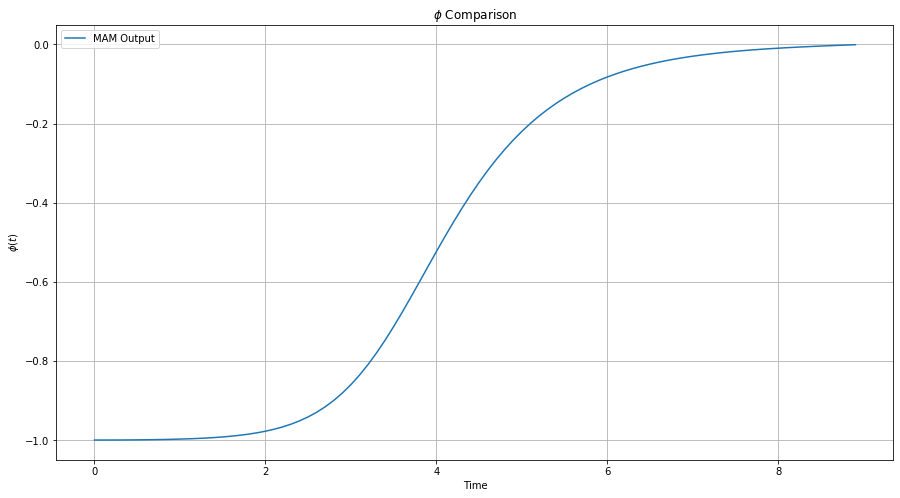

In [31]:
# Comparison Plot

fig, ax = plt.subplots(figsize=(15, 8))

ax.grid()
ax.set_title('$\\phi$ Comparison')
ax.plot(time, ou_mam.instanton, label = 'MAM Output')
ax.set_xlabel('Time')
ax.set_ylabel('$\\phi(t)$')
ax.legend()
fig.show()

## Calculating action For Nearby Paths

We compare the action for slightly perturb paths, create a histogram and check if our found path does indeed minimise.

In [32]:
# Creating A Load Of Random Paths to compare against

near_paths = [random_path(ou_mam.instanton, 0.01) for i in range(10000)] # Conclusion Different depending on paths
# near_paths = [random_path(ou_mam.instanton, 0.001) for i in range(10000)]

In [34]:
# Creating Object to Track Action Check

action_track = action_minimisation_checker(drift, ou_mam.instanton, [s, time, Dinv])

TypeError: drift() takes 2 positional arguments but 3 were given

In [ ]:
# Doing the Comparison

for path in near_paths:
    action_track.compare(path)

In [ ]:
# Histogram 

fig, ax = plt.subplots(figsize=(15, 8))

ax.grid()
bins, edges, patches = ax.hist(action_track.av_list, bins=100, density=True)
ax.plot(np.full_like(np.linspace(0, max(bins)), action_track.action_value), 
        np.linspace(0, max(bins)), '--o', label='MAM Instanton')
ax.set_xlabel('Action Value')
ax.set_ylabel('$\\rho$')
ax.set_title('Action Density For Nearby Paths')
ax.legend()
fig.show()